# 프로젝트: CutMix 또는 Mixup 비교실험 하기

목표 : CutMix와 Mixup 적용하여 실험하기 

*프로젝트 설명 : 지금까지 기본적인 augmentation 방법을 적용해 모델을 훈련시키고, 최신 augmentation 기법을 배워 보았습니다.*
*이번에는 최신 기법(CutMix 또는 Mixup)을 적용해 모델을 훈련시켜 봅시다. 데이터셋에 두 가지 방법 중 하나를 적용하고, 모델을 학습시켜 주세요. 결과를 수치화하고 비교하는 것도 잊지마세요!*  

## 0. 임포트 및 데이터 가져오기

In [2]:
# TensorFlow and tf.keras
import tensorflow as tf
from tensorflow import keras

# Helper libraries
import numpy as np
import matplotlib.pyplot as plt

import tensorflow_datasets as tfds


In [3]:
tf.config.list_physical_devices('GPU')

[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]

In [4]:
import urllib3
urllib3.disable_warnings()
(ds_train, ds_test), ds_info = tfds.load(
    'stanford_dogs',
    split=['train','test'],
    as_supervised=True, # ?
    shuffle_files=True,
    with_info=True,
)

The old signature is deprecated and will be removed. Please change your call to `tfds.show_examples(ds, info)`


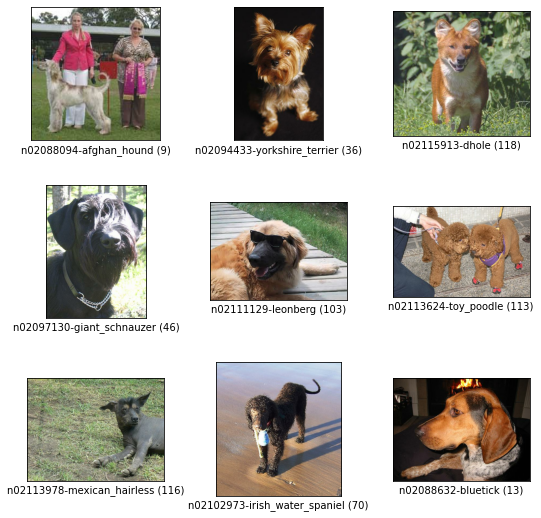

In [5]:
fig = tfds.show_examples(ds_info, ds_train)

In [6]:
NUM_CLASSES = ds_info.features["label"].num_classes

## 1. Augmentation을 적용한 데이터셋 만들기
*Step설명 : 이전 스텝과 아래 코드를 참고하여 데이터셋에 CutMix 또는 Mixup augmentation을 적용해 주세요.*

**Q1. 아래는 CutMix를 적용할 수 있도록 변경한 apply_normalize_on_dataset()입니다. batch() 함수 뒤에 CutMix가 오도록 만들어야합니다. 그 이유가 뭘까요?** 
- CutMix는 배치 안에 있는 이미지끼리만 섞는 과정이기 때문에, 미리 배치 단위로 데이터셋을 정렬 후 CutMix가 적용되어야 한다.

### 1-1. 바운딩 박스의 위치를 랜덤하게 뽑고 이미지 잘라내는 함수 

In [7]:
def get_clip_box(image_a, image_b):
    # image.shape = (height, width, channel)
    image_size_x = image_a.shape[1]
    image_size_y = image_a.shape[0]
    
    # get center of box
    x = tf.cast( tf.random.uniform([],0, image_size_x),tf.int32)
    y = tf.cast( tf.random.uniform([],0, image_size_y),tf.int32)

    # get width, height of box
    width = tf.cast(image_size_x * tf.math.sqrt(1-tf.random.uniform([],0,1)),tf.int32)
    height = tf.cast(image_size_y * tf.math.sqrt(1-tf.random.uniform([],0,1)),tf.int32)
    
    # clip box in image and get minmax bbox
    xa = tf.math.maximum(0, x-width//2)
    ya = tf.math.maximum(0, y-height//2)
    xb = tf.math.minimum(image_size_x, x+width//2)
    yb = tf.math.minimum(image_size_y, y+width//2)
    
    return xa, ya, xb, yb

### 1-2. 두 이미지를 섞는 함수

In [8]:
# mix two images
def mix_2_images(image_a, image_b, xa, ya, xb, yb):
    image_size_x = image_a.shape[1]
    image_size_y = image_a.shape[0] 
    one = image_a[ya:yb,0:xa,:]
    two = image_b[ya:yb,xa:xb,:]
    three = image_a[ya:yb,xb:image_size_x,:]
    middle = tf.concat([one,two,three],axis=1)
    top = image_a[0:ya,:,:]
    bottom = image_a[yb:image_size_y,:,:]
    mixed_img = tf.concat([top, middle, bottom],axis=0)
    
    return mixed_img

### 1-3. 면적에 비례해서 라벨을 섞기

In [9]:
# mix two labels
def mix_2_label(image_a, image_b, label_a, label_b, xa, ya, xb, yb, num_classes=NUM_CLASSES):
    image_size_x = image_a.shape[1]
    image_size_y = image_a.shape[0] 
    mixed_area = (xb-xa)*(yb-ya)
    total_area = image_size_x*image_size_y
    a = tf.cast(mixed_area/total_area, tf.float32)

    if len(label_a.shape)==0:
        label_a = tf.one_hot(label_a, num_classes)
    if len(label_b.shape)==0:
        label_b = tf.one_hot(label_b, num_classes)
    mixed_label = (1-a)*label_a + a*label_b
    return mixed_label

### 1-4. 배치 단위의 cutmix 함수 

In [10]:
def cutmix(image, label, prob = 1.0, batch_size=16, img_size=224, num_classes=NUM_CLASSES):
    mixed_imgs = []
    mixed_labels = []

    for i in range(batch_size):
        image_a = image[i]
        label_a = label[i]
        j = tf.cast(tf.random.uniform([],0, batch_size),tf.int32)
        image_b = image[j]
        label_b = label[j]
        xa, ya, xb, yb = get_clip_box(image_a, image_b)
        mixed_imgs.append(mix_2_images(image_a, image_b, xa, ya, xb, yb))
        mixed_labels.append(mix_2_label(image_a, image_b, label_a, label_b, xa, ya, xb, yb))

    mixed_imgs = tf.reshape(tf.stack(mixed_imgs),(batch_size, img_size, img_size, 3))
    mixed_labels = tf.reshape(tf.stack(mixed_labels),(batch_size, num_classes))
    return mixed_imgs, mixed_labels

### 1-5. mixup 함수 

In [11]:
# function for mixup
def mixup_2_images(image_a, image_b, label_a, label_b):
    a = tf.random.uniform([],0,1)
    
    if len(label_a.shape)==0:
        label_a = tf.one_hot(label_a, NUM_CLASSES)
    if len(label_b.shape)==0:
        label_b = tf.one_hot(label_b, NUM_CLASSES)
    mixed_image= (1-a)*image_a + a*image_b
    mixed_label = (1-a)*label_a + a*label_b
    
    return mixed_image, mixed_label

In [12]:
def mixup(image, label, prob = 1.0, batch_size=16, img_size=224, num_classes=NUM_CLASSES):
    mixed_imgs = []
    mixed_labels = []

    for i in range(batch_size):
        image_a = image[i]
        label_a = label[i]
        j = tf.cast(tf.random.uniform([],0, batch_size),tf.int32)
        image_b = image[j]
        label_b = label[j]
        mixed_img, mixed_label = mixup_2_images(image_a, image_b, label_a, label_b)
        mixed_imgs.append(mixed_img)
        mixed_labels.append(mixed_label)

    mixed_imgs = tf.reshape(tf.stack(mixed_imgs),(batch_size, img_size, img_size, 3))
    mixed_labels = tf.reshape(tf.stack(mixed_labels),(batch_size, num_classes))
    return mixed_imgs, mixed_labels

### 1-5. 사이즈 변경, 정규화, augment, cutmix, mixup 적용 함수 

In [13]:
def normalize_and_resize_img(image, label):
    """Normalizes images: `uint8` -> `float32`."""
    image = tf.image.resize(image, [224, 224])
    return tf.cast(image, tf.float32) / 255., label

def augment(image,label):
    image = tf.image.random_flip_left_right(image)
    image = tf.image.random_brightness(image, max_delta=0.2)
    return image,label

def onehot(image, label):
    label_onehot = tf.one_hot(label, NUM_CLASSES)
    return image, label_onehot

# 테스트 데이터셋을 위한 가공 - cutmix를 사용할 때는 테스트데이터셋도 one-hot으로 변경해줌 
def apply_normalize_on_test_dataset(ds, batch_size=16, with_onehot=False):
    ds = ds.map(
        normalize_and_resize_img,  # 기본적인 전처리 함수 적용
        num_parallel_calls=2
    )
    ds = ds.batch(batch_size)
    if with_onehot:
        ds = ds.map(
            onehot,
            num_parallel_calls=2
        )
    ds = ds.prefetch(tf.data.experimental.AUTOTUNE)
    return ds

# 훈련 데이터셋을 위한 가공
def apply_normalize_on_train_dataset(ds, batch_size=16, with_aug=False, with_cutmix=False, with_mixup=False):
    ds = ds.map(
        normalize_and_resize_img, 
        num_parallel_calls=2
    )
    if with_aug:
        ds = ds.map(
            augment
        )
    ds = ds.batch(batch_size)
    if with_mixup:
        ds = ds.map(
            mixup,
            num_parallel_calls=2
        )
    if with_cutmix:
        ds = ds.map(
            cutmix,
            num_parallel_calls=2
        )
    ds = ds.repeat()
    ds = ds.shuffle(200)
    ds = ds.prefetch(tf.data.experimental.AUTOTUNE)
    return ds

In [33]:
ds_train_no_cutmix = apply_normalize_on_train_dataset(ds_train)
ds_train_cutmix = apply_normalize_on_train_dataset(ds_train, with_cutmix=True)

In [34]:
ds_aug_test = apply_normalize_on_test_dataset(ds_test)
ds_onehot_test = apply_normalize_on_test_dataset(ds_test, with_onehot=True)

## 2. 모델 만들기
*Step설명 : 앞서 만들었던 것처럼 비교실험을 위한 모델 두 개를 만들어 주세요. 모델은 ResNet-50을 사용합시다.*

### 2-1. no augmentation 이미지 사용 모델 

In [29]:
resnet50 = keras.models.Sequential([
    keras.applications.resnet.ResNet50(
        include_top = False,
        weights='imagenet',
        input_shape=(224,224,3),
        pooling='avg',
    ),
    keras.layers.Dense(NUM_CLASSES, activation='softmax')
])

In [30]:
resnet50.summary()

Model: "sequential_4"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
resnet50 (Model)             (None, 2048)              23587712  
_________________________________________________________________
dense_4 (Dense)              (None, 120)               245880    
Total params: 23,833,592
Trainable params: 23,780,472
Non-trainable params: 53,120
_________________________________________________________________


### 2-2. cutmix 이미지 사용 모델

In [31]:
cutmix_resnet50 = keras.models.Sequential([
    keras.applications.resnet.ResNet50(
        include_top=False,
        weights='imagenet',
        input_shape=(224,224,3),
        pooling='avg',
    ),
    keras.layers.Dense(NUM_CLASSES, activation='softmax')
])

In [32]:
cutmix_resnet50.summary()

Model: "sequential_5"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
resnet50 (Model)             (None, 2048)              23587712  
_________________________________________________________________
dense_5 (Dense)              (None, 120)               245880    
Total params: 23,833,592
Trainable params: 23,780,472
Non-trainable params: 53,120
_________________________________________________________________


## 3. 모델 훈련하기
*Step설명 : 모델을 훈련시켜 주세요.*

*Step설명 : _힌트 위에서 만든 CutMix나 Mixup을 사용하기 위해서는 앞에서 resnet50과 aug_resnet50을 훈련하는 데 사용했던 sparse_categorical_crossentropy() 대신 categorical_crossentropy()를 사용해주세요* 

**Q3. sparse_categorical_crossentropy()를 사용하지 못하는 이유가 뭘까요?**   
- categorical_crossentropy() 는  one-hot encoding된 결과로 출력되고 실측 결과와의 비교시에도 one-hot encoding 형태로 구성된다.   
- sparse_categorical_corossentropy()는 integer type 클래스라는 것이 다르다.     
- cutmix(), mixup()을 구현하면서 label의 mix 때문에 더이상 label이 스칼라값을 가지지 못하고 One-Hot 벡터 형태로 변환되었기 때문이다. 

### 3-1. no augmentation 이미지 사용 모델 훈련

In [35]:
EPOCH = 20  # Cutmix 적용 효과를 확인하기 위해 필요한 epoch 수
#EPOCH = 3

tf.random.set_seed(2020)
resnet50.compile(
    loss='sparse_categorical_crossentropy',
    optimizer=tf.keras.optimizers.SGD(lr=0.01),
    metrics=['accuracy'],
)


history_resnet50_no_cutmix = resnet50.fit(
    ds_train_no_cutmix, # Cutmix 적용하지 않은 데이터셋 사용
    steps_per_epoch=int(ds_info.splits['train'].num_examples/16),
    validation_steps=int(ds_info.splits['test'].num_examples/16),
    epochs=EPOCH,
    validation_data=ds_aug_test,
    verbose=1,
    use_multiprocessing=True,
)



Epoch 1/20
750/750 [==============================] - 109s 145ms/step - loss: 2.2202 - accuracy: 0.4456 - val_loss: 3.1616 - val_accuracy: 0.2492
Epoch 2/20
750/750 [==============================] - 108s 144ms/step - loss: 0.7737 - accuracy: 0.7842 - val_loss: 1.1506 - val_accuracy: 0.6665
Epoch 3/20
750/750 [==============================] - 108s 144ms/step - loss: 0.2852 - accuracy: 0.9350 - val_loss: 1.0073 - val_accuracy: 0.7098
Epoch 4/20
750/750 [==============================] - 108s 145ms/step - loss: 0.1164 - accuracy: 0.9843 - val_loss: 0.9292 - val_accuracy: 0.7337
Epoch 5/20
750/750 [==============================] - 108s 144ms/step - loss: 0.0438 - accuracy: 0.9968 - val_loss: 0.8992 - val_accuracy: 0.7408
Epoch 6/20
750/750 [==============================] - 108s 145ms/step - loss: 0.0192 - accuracy: 0.9992 - val_loss: 0.9095 - val_accuracy: 0.7457
Epoch 7/20
750/750 [==============================] - 109s 145ms/step - loss: 0.0218 - accuracy: 0.9987 - val_loss: 0.9428 -

### 3-2. cutmix 이미지 사용 모델 훈련

In [36]:
EPOCH = 20  # Cutmix 적용 효과를 확인하기 위해 필요한 epoch 수

tf.random.set_seed(2020)
cutmix_resnet50.compile(
    loss='categorical_crossentropy',
    optimizer=tf.keras.optimizers.SGD(lr=0.01),
    metrics=['accuracy'],
)

history_resnet50_cutmix = cutmix_resnet50.fit(
    ds_train_cutmix, # Cutmix 적용한 데이터셋 사용
    steps_per_epoch=int(ds_info.splits['train'].num_examples/16),
    validation_steps=int(ds_info.splits['test'].num_examples/16),
    epochs=EPOCH,
    validation_data=ds_onehot_test,
    verbose=1,
    use_multiprocessing=True,
)


Epoch 1/20
750/750 [==============================] - 111s 148ms/step - loss: 3.8020 - accuracy: 0.2175 - val_loss: 3.0463 - val_accuracy: 0.2633
Epoch 2/20
750/750 [==============================] - 111s 148ms/step - loss: 2.9575 - accuracy: 0.4277 - val_loss: 1.3843 - val_accuracy: 0.6122
Epoch 3/20
750/750 [==============================] - 111s 148ms/step - loss: 2.6606 - accuracy: 0.5217 - val_loss: 1.2756 - val_accuracy: 0.6588
Epoch 4/20
750/750 [==============================] - 111s 148ms/step - loss: 2.4476 - accuracy: 0.5911 - val_loss: 1.1535 - val_accuracy: 0.6848
Epoch 5/20
750/750 [==============================] - 111s 148ms/step - loss: 2.3162 - accuracy: 0.6377 - val_loss: 1.3623 - val_accuracy: 0.6270
Epoch 6/20
750/750 [==============================] - 111s 148ms/step - loss: 2.2063 - accuracy: 0.6705 - val_loss: 1.2767 - val_accuracy: 0.6569
Epoch 7/20
750/750 [==============================] - 110s 147ms/step - loss: 2.1128 - accuracy: 0.6966 - val_loss: 1.1773 -

## 4. 훈련 과정 시각화하기
*Step설명 : 훈련 과정의 히스토리를 그래프로 시각화해 주세요.*


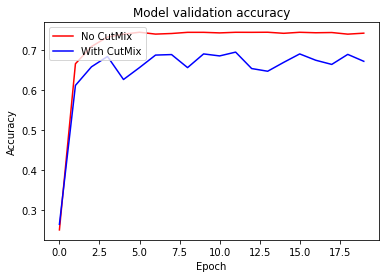

In [37]:
plt.plot(history_resnet50_no_cutmix.history['val_accuracy'], 'r')
plt.plot(history_resnet50_cutmix.history['val_accuracy'], 'b')
plt.title('Model validation accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['No CutMix', 'With CutMix'], loc='upper left')
plt.show()

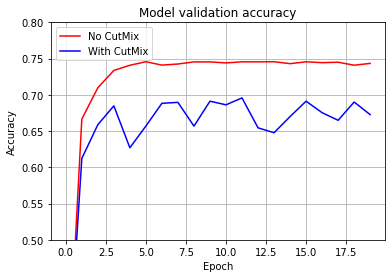

In [38]:
plt.plot(history_resnet50_no_cutmix.history['val_accuracy'], 'r')
plt.plot(history_resnet50_cutmix.history['val_accuracy'], 'b')
plt.title('Model validation accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['No CutMix', 'With CutMix'], loc='upper left')
plt.grid(True)
plt.ylim(0.50, 0.80)    # 출력하고자 하는  Accuracy 범위를 지정해 주세요. 
#plt.ylim(0.72, 0.76)  # EPOCH=20으로 진행한다면 이 범위가 적당합니다. 
plt.show()

Cutmix한 데이터셋을 사용한 모델이 성능이 좋을 것으로 기대했으나, 예상과는 다르게 Cutmix를 하지 않은 모델이 더 성능이 좋음.

## 5. Augmentation에 의한 모델 성능 비교
*Step설명 : No Augmentation, 기본 Augmentation, 기본 + CutMix 적용, 기본 + Mixup 적용 이상 4가지 경우의 데이터셋에 대해 훈련된 ResNet50 분류기의 견종 분류 정확도 성능을 비교해 보고, Augmentation 방법들의 영향도에 대해 분석해 보세요.*  

In [15]:
ds_train_no_aug = apply_normalize_on_train_dataset(ds_train)

In [16]:
ds_train_aug = apply_normalize_on_train_dataset(ds_train, with_aug=True)

In [17]:
ds_train_aug_cutmix = apply_normalize_on_train_dataset(ds_train,  with_aug=True, with_cutmix=True)

In [18]:
ds_train_aug_mixup = apply_normalize_on_train_dataset(ds_train,  with_aug=True, with_mixup=True)

### 5-1. No Augmentation

In [19]:
no_aug_resnet50 = keras.models.Sequential([
    keras.applications.resnet.ResNet50(
        include_top=False,
        weights='imagenet',
        input_shape=(224,224,3),
        pooling='avg',
    ),
    keras.layers.Dense(NUM_CLASSES, activation='softmax')
])

In [23]:
EPOCH = 20  

tf.random.set_seed(2020)
no_aug_resnet50.compile(
    loss='sparse_categorical_crossentropy',
    optimizer=tf.keras.optimizers.SGD(lr=0.01),
    metrics=['accuracy'],
)

history_resnet50_no_aug = no_aug_resnet50.fit(
    ds_train_no_aug, # augmentation 적용하지 않은 데이터셋 사용
    steps_per_epoch=int(ds_info.splits['train'].num_examples/16),
    validation_steps=int(ds_info.splits['test'].num_examples/16),
    epochs=EPOCH,
    validation_data=ds_aug_test,
    verbose=1,
    use_multiprocessing=True,
)

Epoch 1/20
750/750 [==============================] - 108s 144ms/step - loss: 2.2166 - accuracy: 0.4454 - val_loss: 3.3126 - val_accuracy: 0.2191
Epoch 2/20
750/750 [==============================] - 108s 144ms/step - loss: 0.7559 - accuracy: 0.7926 - val_loss: 1.1054 - val_accuracy: 0.6742
Epoch 3/20
750/750 [==============================] - 108s 144ms/step - loss: 0.2794 - accuracy: 0.9363 - val_loss: 0.9949 - val_accuracy: 0.7077
Epoch 4/20
750/750 [==============================] - 108s 144ms/step - loss: 0.1021 - accuracy: 0.9852 - val_loss: 0.9289 - val_accuracy: 0.7344
Epoch 5/20
750/750 [==============================] - 107s 143ms/step - loss: 0.0350 - accuracy: 0.9979 - val_loss: 0.9139 - val_accuracy: 0.7410
Epoch 6/20
750/750 [==============================] - 107s 143ms/step - loss: 0.0190 - accuracy: 0.9989 - val_loss: 0.9479 - val_accuracy: 0.7353
Epoch 7/20
750/750 [==============================] - 107s 143ms/step - loss: 0.0226 - accuracy: 0.9984 - val_loss: 0.9498 -

### 5-2. 기본 Augmentation

In [20]:
aug_resnet50 = keras.models.Sequential([
    keras.applications.resnet.ResNet50(
        include_top=False,
        weights='imagenet',
        input_shape=(224,224,3),
        pooling='avg',
    ),
    keras.layers.Dense(NUM_CLASSES, activation='softmax')
])


In [24]:
EPOCH = 20  

tf.random.set_seed(2020)
aug_resnet50.compile(
    loss='sparse_categorical_crossentropy',
    optimizer=tf.keras.optimizers.SGD(lr=0.01),
    metrics=['accuracy'],
)

history_resnet50_aug = aug_resnet50.fit(
    ds_train_aug, # augmentation 적용하지 않은 데이터셋 사용
    steps_per_epoch=int(ds_info.splits['train'].num_examples/16),
    validation_steps=int(ds_info.splits['test'].num_examples/16),
    epochs=EPOCH,
    validation_data=ds_aug_test,
    verbose=1,
    use_multiprocessing=True,
)

Epoch 1/20
750/750 [==============================] - 108s 144ms/step - loss: 2.2422 - accuracy: 0.4396 - val_loss: 2.5912 - val_accuracy: 0.3372
Epoch 2/20
750/750 [==============================] - 108s 145ms/step - loss: 0.9563 - accuracy: 0.7218 - val_loss: 1.6983 - val_accuracy: 0.5366
Epoch 3/20
750/750 [==============================] - 109s 145ms/step - loss: 0.5370 - accuracy: 0.8495 - val_loss: 1.1533 - val_accuracy: 0.6632
Epoch 4/20
750/750 [==============================] - 109s 145ms/step - loss: 0.3066 - accuracy: 0.9187 - val_loss: 1.1694 - val_accuracy: 0.6749
Epoch 5/20
750/750 [==============================] - 109s 145ms/step - loss: 0.1600 - accuracy: 0.9647 - val_loss: 0.9971 - val_accuracy: 0.7165
Epoch 6/20
750/750 [==============================] - 109s 145ms/step - loss: 0.1055 - accuracy: 0.9821 - val_loss: 1.0307 - val_accuracy: 0.7113
Epoch 7/20
750/750 [==============================] - 109s 145ms/step - loss: 0.0771 - accuracy: 0.9879 - val_loss: 1.0400 -

### 5-3. 기본 Augmentation + CutMix 적용

In [21]:
aug_cutmix_resnet50 = keras.models.Sequential([
    keras.applications.resnet.ResNet50(
        include_top=False,
        weights='imagenet',
        input_shape=(224,224,3),
        pooling='avg',
    ),
    keras.layers.Dense(NUM_CLASSES, activation='softmax')
])

In [25]:
EPOCH = 20 

tf.random.set_seed(2020)
aug_cutmix_resnet50.compile(
    loss='categorical_crossentropy',
    optimizer=tf.keras.optimizers.SGD(lr=0.01),
    metrics=['accuracy'],
)

history_resnet50_aug_cutmix = aug_cutmix_resnet50.fit(
    ds_train_aug_cutmix, # Cutmix 적용한 데이터셋 사용
    steps_per_epoch=int(ds_info.splits['train'].num_examples/16),
    validation_steps=int(ds_info.splits['test'].num_examples/16),
    epochs=EPOCH,
    validation_data=ds_onehot_test,
    verbose=1,
    use_multiprocessing=True,
)


Epoch 1/20
750/750 [==============================] - 110s 147ms/step - loss: 3.8602 - accuracy: 0.2083 - val_loss: 2.7905 - val_accuracy: 0.2908
Epoch 2/20
750/750 [==============================] - 111s 148ms/step - loss: 3.0284 - accuracy: 0.4089 - val_loss: 1.3433 - val_accuracy: 0.6198
Epoch 3/20
750/750 [==============================] - 111s 148ms/step - loss: 2.7500 - accuracy: 0.4882 - val_loss: 1.2279 - val_accuracy: 0.6521
Epoch 4/20
750/750 [==============================] - 111s 148ms/step - loss: 2.5802 - accuracy: 0.5428 - val_loss: 1.2536 - val_accuracy: 0.6427
Epoch 5/20
750/750 [==============================] - 112s 149ms/step - loss: 2.4494 - accuracy: 0.5844 - val_loss: 1.5014 - val_accuracy: 0.5913
Epoch 6/20
750/750 [==============================] - 112s 149ms/step - loss: 2.3370 - accuracy: 0.6202 - val_loss: 1.2957 - val_accuracy: 0.6434
Epoch 7/20
750/750 [==============================] - 112s 149ms/step - loss: 2.2279 - accuracy: 0.6541 - val_loss: 1.1800 -

### 5-4. 기본 Augmentation + Mixup

In [22]:
aug_mixup_resnet50 = keras.models.Sequential([
    keras.applications.resnet.ResNet50(
        include_top=False,
        weights='imagenet',
        input_shape=(224,224,3),
        pooling='avg',
    ),
    keras.layers.Dense(NUM_CLASSES, activation='softmax')
])


In [26]:
EPOCH = 20 

tf.random.set_seed(2020)
aug_mixup_resnet50.compile(
    loss='categorical_crossentropy',
    optimizer=tf.keras.optimizers.SGD(lr=0.01),
    metrics=['accuracy'],
)


history_resnet50_aug_mixup = aug_mixup_resnet50.fit(
    ds_train_aug_mixup, # Cutmix 적용한 데이터셋 사용
    steps_per_epoch=int(ds_info.splits['train'].num_examples/16),
    validation_steps=int(ds_info.splits['test'].num_examples/16),
    epochs=EPOCH,
    validation_data=ds_onehot_test,
    verbose=1,
    use_multiprocessing=True,
)

Epoch 1/20
750/750 [==============================] - 113s 150ms/step - loss: 3.7267 - accuracy: 0.2439 - val_loss: 3.7271 - val_accuracy: 0.1491
Epoch 2/20
750/750 [==============================] - 112s 150ms/step - loss: 2.9349 - accuracy: 0.4507 - val_loss: 1.3960 - val_accuracy: 0.6061
Epoch 3/20
750/750 [==============================] - 113s 150ms/step - loss: 2.6801 - accuracy: 0.5422 - val_loss: 1.4120 - val_accuracy: 0.5989
Epoch 4/20
750/750 [==============================] - 111s 149ms/step - loss: 2.5077 - accuracy: 0.6099 - val_loss: 1.2341 - val_accuracy: 0.6529
Epoch 5/20
750/750 [==============================] - 113s 150ms/step - loss: 2.3844 - accuracy: 0.6469 - val_loss: 1.2658 - val_accuracy: 0.6493
Epoch 6/20
750/750 [==============================] - 112s 150ms/step - loss: 2.3077 - accuracy: 0.6785 - val_loss: 1.4170 - val_accuracy: 0.6220
Epoch 7/20
750/750 [==============================] - 112s 150ms/step - loss: 2.2429 - accuracy: 0.7097 - val_loss: 1.2432 -

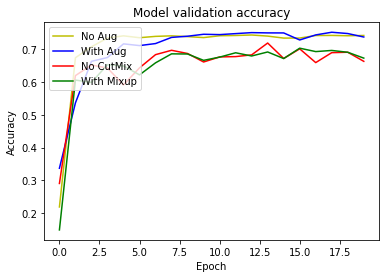

In [27]:
plt.plot(history_resnet50_no_aug.history['val_accuracy'], 'y')
plt.plot(history_resnet50_aug.history['val_accuracy'], 'b')
plt.plot(history_resnet50_aug_cutmix.history['val_accuracy'], 'r')
plt.plot(history_resnet50_aug_mixup.history['val_accuracy'], 'g')
plt.title('Model validation accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['No Aug', 'With Aug','No CutMix', 'With Mixup'], loc='upper left')
plt.show()

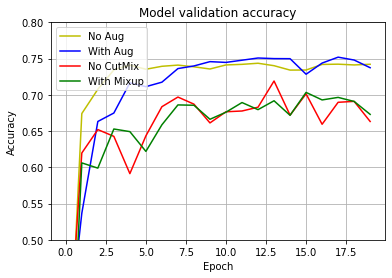

In [39]:
plt.plot(history_resnet50_no_aug.history['val_accuracy'], 'y')
plt.plot(history_resnet50_aug.history['val_accuracy'], 'b')
plt.plot(history_resnet50_aug_cutmix.history['val_accuracy'], 'r')
plt.plot(history_resnet50_aug_mixup.history['val_accuracy'], 'g')
plt.title('Model validation accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['No Aug', 'With Aug','No CutMix', 'With Mixup'], loc='upper left')
plt.grid(True)
plt.ylim(0.50, 0.80)    # 출력하고자 하는  Accuracy 범위를 지정해 주세요. 
#plt.ylim(0.72, 0.76)  # EPOCH=20으로 진행한다면 이 범위가 적당합니다. 
plt.show()

훈련이 진행될수록 기본적인 Augmentation을 한 데이터셋에서 성능이 가장 좋았다.   
CutMix와 Mixup은 기본 Augmentation 기법에 비해 성능은 좋지 않았다. 


## 느낀점
딥러닝 모델을 훈련시키기 위해선 대량의 데이터가 필요한데 그 데이터를 최대한 활용하기 위해 사용되는 Augmentation기법을 배웠다. 
Flipping, Gray scale, Saturation, Brightness, Rotation 등 다양한 기법들이 있고, 최근에 나온 CutMix와 Mixup을 사용해서 프로젝트가 진행되었다. 
CutMix와 Mixup의 결과가 one-hot encoding으로 구성되었기 때문에 훈련시 loss를 계산할 때 categorical_crossentropy()를 사용하였다. 
기본 Augmentation이나 Augmentation을 이용하지 않는 데이터 셋에서는 loss 계산시 sparse_categorical_crossentropy()를 사용했다. 
새로운 기법으로 소개된 CutMix와 Mixup이 좋은 성능을 낼 줄 알았는데, Augmentation을 하지 않을 때보다 성능이 좋지 않아서 아쉽다. 